# Attention is All You Need Deep Dive

Progressing from convolutional sequence to sequence and attension is all you need slide from class, the following is an implementation following a detailed tutorial (https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb) modified from the origional "attension is all you need" paper. In this tutorial we implement a functional translator that takes in a string in one language, encodes the input into a context vector, and then decodes from the context vector into our desired translation language. All explainations and comments are written origionally in this notebook, while some code is written and some is borrowed from the above tutorial. The main difference between attension and the implementation approach in this notebook is the use of a "Transformer" model that does not use recurrence or convolutional hidden layers. Transformers have become the most common translation method by performing best and having a linear layer architecture.  



## Language Data
Before we approach the development, we need language data of at least two languages. The spacy package in python has many languages available in its database. In our implementation we will be translating between german and english. Unfortunately the Multi30 package from the tutorial only supports German, however spacy does host multiple languages, so an extension from this notebook could be building a translator that works for multiple languages. 

In [1]:
import spacy

#!python -m spacy download 'en_core_web_sm'
#!python -m spacy download 'de_core_news_sm'

spacy_en = spacy.load('en_core_web_sm')   #English
spacy_de = spacy.load('de_core_news_sm')  #German

In [2]:
import torch
import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator


def tokenize_de(text): #German tokenization
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text): #english tokenization
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, #encoded vector
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, #decoded vector
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits( #split data sets
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

At this stage we have uploaded the German and English data, tokenized the text from a long string of words to a vector of words, tokenized the beginning and end of the sentences, as well as split the dataset into training and testing (and validating) data. 

In [3]:
import torch.nn as nn
import torch.optim as optim

#First, token embedding class for context vectorization.
#masking the input language data for interpretation
class Encoder(nn.Module): 
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim) # first embedding size transition from input to hidden dim
        self.pos_embedding = nn.Embedding(max_length, hid_dim) # positional embedding size
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask): #Foreward encoding of language data standard to what we did last report
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        for layer in self.layers:
            src = layer(src, src_mask)
        return src #mask out



Now after the input language data is "prepped", we can encode using the MultiHeadAttentionLayer(). This function we write and describe below this block just following the order of the tutorial.  

In [4]:
#Embedding into context vector
class EncoderLayer(nn.Module):
    def __init__(self,hid_dim, n_heads, pf_dim,  dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim) 
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)  
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src #context vector out

In the above code we have introduced attention (the main topic of this investigation). This was introduced in the MultiHeadAttentionLayer call that is used in the forward encoding layer for context vector embedding. Transformers are generally defined as the softmax of the product between query and key (labeled in the comments below). However following the attention is all you need publication, we get a little smarter here by splitting the hidden dimention into "heads" which can be computed in parrallel with "linear layers" to re-adjust shape. Basically, these assign values to each word in the sentence and their similarity to all the other words in the sentence given the word and its position. This similarity is referred to as "attention". Some more mathematics is labelled in the comments below.

In [5]:
from bertviz import head_view
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads #calculating un-normalized attention (multiplying query and key)
        
        self.fc_q = nn.Linear(hid_dim, hid_dim) #linear layers here
        self.fc_k = nn.Linear(hid_dim, hid_dim) #linear layers here
        self.fc_v = nn.Linear(hid_dim, hid_dim) #linear layers here
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]   
        Q = self.fc_q(query) #query 
        K = self.fc_k(key)   #key
        V = self.fc_v(value) #value
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) #.view splits the the hidden dimention into n heads
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)     
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale #unnormalized attention value
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10) #don't use irrelevant data
        attention = torch.softmax(energy, dim = -1) #normalized attention with softmax    
        x = torch.matmul(self.dropout(attention), V) #sizing here is [query len, key len] x [value len, head dim] -> [batch size, n heads, query len, head dim] 
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)
        
        return x, attention #attention value returned
    



Above was the first encoding necessary to develop the context vector embedding. Next, we also need to embed the context vector. In the offical paper of All You Need Is Attention, they use static positioning, however more modern applications have standardized having dynamic positional encoding so we will include it here. For position encoding, we expand the hidden dimention to a larger positional factor dimention (in this case 512 -> 2048). For the foreward activation function, the tutorial and the origional paper use the standard relu function. Apparently this is never explained why, so we will take some time to test some alternatives and decide if this was indeed a good idea. One popular activation function used today is GELU, which is used in the leading model for translation (BERT).

In [6]:
#Secondly, we include postional encoding layer
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim) 
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = self.dropout(torch.relu(self.fc_1(x))) #ReLU
        x = self.dropout(nn.functional.gelu(self.fc_1(x)))  #GELU -- from BERT
        x = self.fc_2(x) #switch back to hidden dimention size
        
        return x #return positional embedding

By straying from the tutorial to investigate different activation functions, we found that GELU was the best by having the lowest training loss (1.65) and most correct translations and attention context assignments. ReLU was very decent in a close second. We tried some other activation functions such as tanh however these were not quite as good. 

Now to go the "other way" (ie decoding) because we need to develop our model that can interpret our context vector and output a new language. More specifically, we will go through two layers of attention called "self_attention" (what we useed in the encoding) and "encoder_attention". The self attention performs the same query, key, value operations. The encoder attention recieves the encoded source that are again masked to prevent the layer from focusing on pad tokens. Intuitively this is nearly the opposite order from the encoding layer, however we need to incoorperate attention operations in both now because the layer and data is still in the attention transformer states. 

In [7]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim,  dropout, device) for _ in range(n_layers)]) #Using decoding layer
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) 
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        output = self.fc_out(trg)
        return output, attention

class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg)) #self attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask) #encoder attention
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg)) #dropout, residual connection, and normalization

        _trg = self.positionwise_feedforward(trg) #Now converting decoded data into language data once again
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        return trg, attention

At this stage in our model, the decoder has mapped our translation into the necessary language, but has yet to change this from "computer language" to the actual language that we desire. To finish up the model, we will follow the sequence to sequence structure from our first notebook to put together order to the above classes in the encode then decode approach. 

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()  
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

    def forward(self, src, trg): 
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention

## Training the Model
Now we input the training set data into the model with an optimizer and loss function and train as we have done for over a semester.

In [9]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device) #put into model

#training weights on model
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE) #adam optimizer

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #loss function

In [10]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]    
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)




Then as we discovered last week, we do the same without gradient calculations in PyTorch methodology

In [11]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad(): #elminiate gradient calculations
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

and train!

In [12]:

import math
import time

def epoch_time(start_time, end_time): #This is a nice function from the tutorial that counts computation time of epochs
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f' Test Loss: {test_loss:.3f}')

Epoch: 01 | Time: 0m 42s
	Train Loss: 4.182 | Train PPL:  65.492
	 Val. Loss: 2.897 |  Val. PPL:  18.120
Epoch: 02 | Time: 0m 42s
	Train Loss: 2.700 | Train PPL:  14.881
	 Val. Loss: 2.213 |  Val. PPL:   9.140
Epoch: 03 | Time: 0m 42s
	Train Loss: 2.145 | Train PPL:   8.539
	 Val. Loss: 1.931 |  Val. PPL:   6.897
Epoch: 04 | Time: 0m 42s
	Train Loss: 1.807 | Train PPL:   6.092
	 Val. Loss: 1.774 |  Val. PPL:   5.893
Epoch: 05 | Time: 0m 42s
	Train Loss: 1.567 | Train PPL:   4.794
	 Val. Loss: 1.701 |  Val. PPL:   5.481
Epoch: 06 | Time: 0m 42s
	Train Loss: 1.385 | Train PPL:   3.995
	 Val. Loss: 1.632 |  Val. PPL:   5.113
Epoch: 07 | Time: 0m 42s
	Train Loss: 1.234 | Train PPL:   3.434
	 Val. Loss: 1.628 |  Val. PPL:   5.093
Epoch: 08 | Time: 0m 42s
	Train Loss: 1.110 | Train PPL:   3.034
	 Val. Loss: 1.618 |  Val. PPL:   5.042
Epoch: 09 | Time: 0m 42s
	Train Loss: 1.003 | Train PPL:   2.725
	 Val. Loss: 1.637 |  Val. PPL:   5.138
Epoch: 10 | Time: 0m 42s
	Train Loss: 0.909 | Train PPL

Following now is a tranlation functino that takes the resulting predition from our learning model and translates it into actual language that we desire. I have commented over their code here for understanding.



In [13]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str): #tokenize source 
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence] 

    tokens = [src_field.init_token] + tokens + [src_field.eos_token] #Add start and end of sentence
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens] #prepare words for computer to understand them

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor) 
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask) #feeder into encoder

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len): #while not max length convert into tensor and decode data

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes] #retokenize to real language
    
    return trg_tokens[1:], attention

Lets try it! The example here generates a translation very close to the predicted result, however it is an example that the model has trained on!!!


In [14]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']
predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


Looking into the attention that was processed here, the tutorial also provided a good looking attention visualization between each language token. 

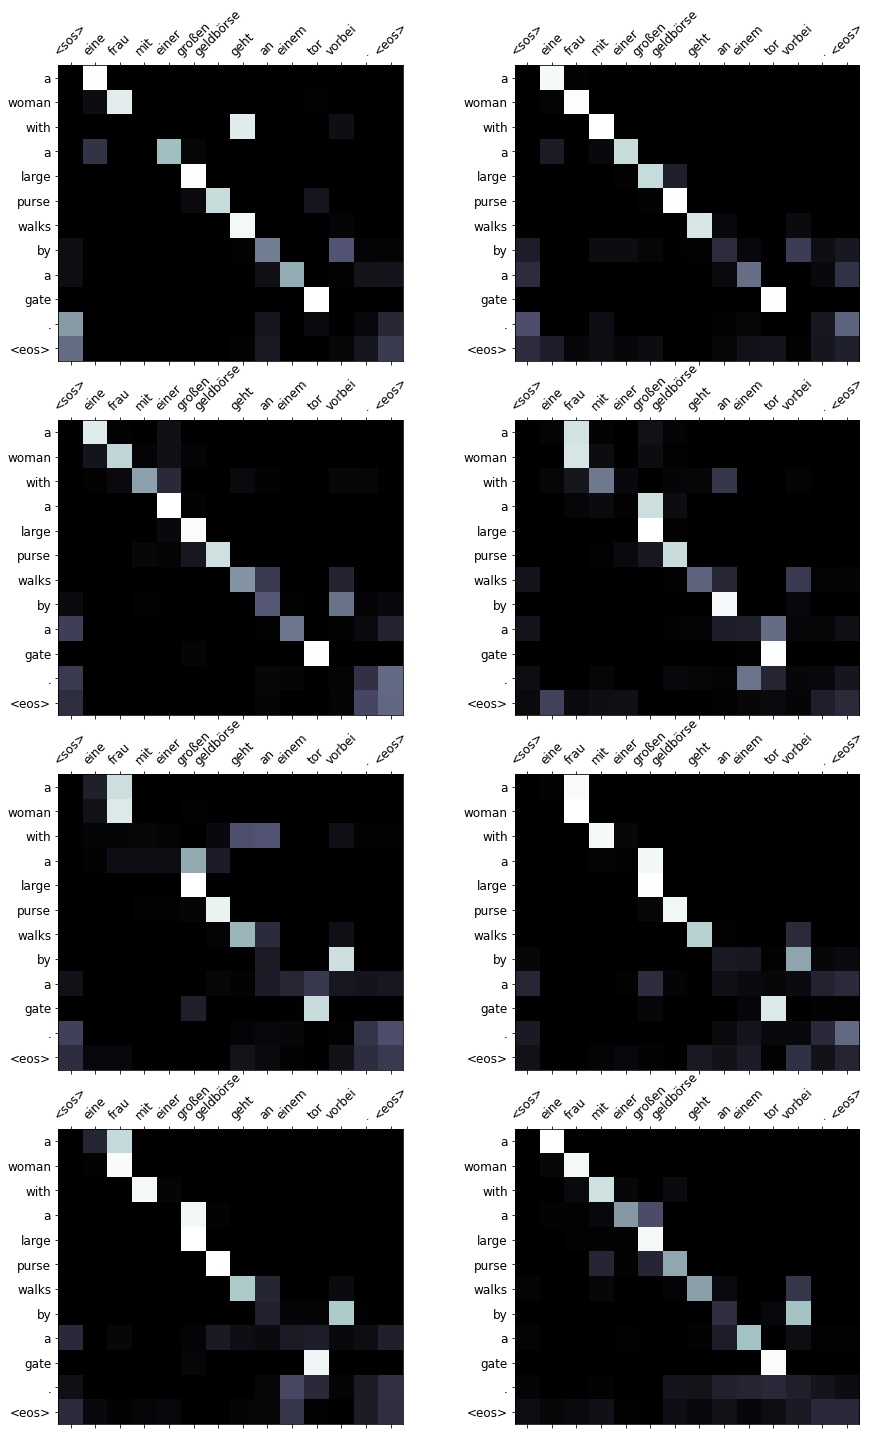

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


display_attention(src, translation, attention)

The following example is from the validation training set, so the model has not been trained on this. 

In [16]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']
predicted trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


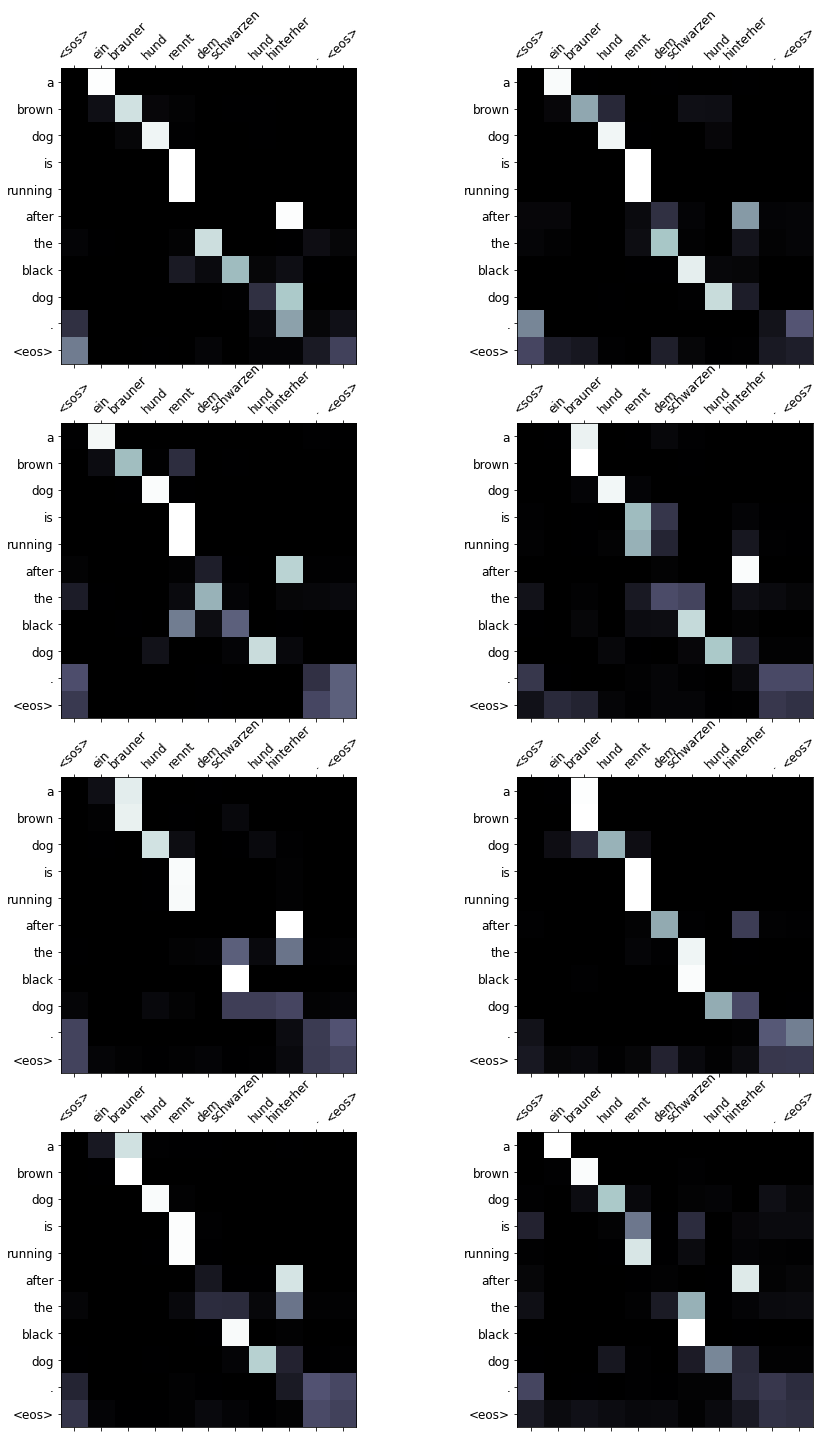

In [17]:
display_attention(src, translation, attention)

The diagonalization that we are seeing is often good because it means the the context interpretation from our model is correctly translating where these words belong in a sentence, alongside the meaning (the most confident attention is to its direct translation). 

The last example here is on test data

In [18]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoy', 'a', 'beautiful', 'day', 'in', 'the', 'day', '.', '<eos>']


Not perfect here, but the meaning is very close in differences of words such as "outside" and "outdoors" which are gramatically interchangeable in this example. 

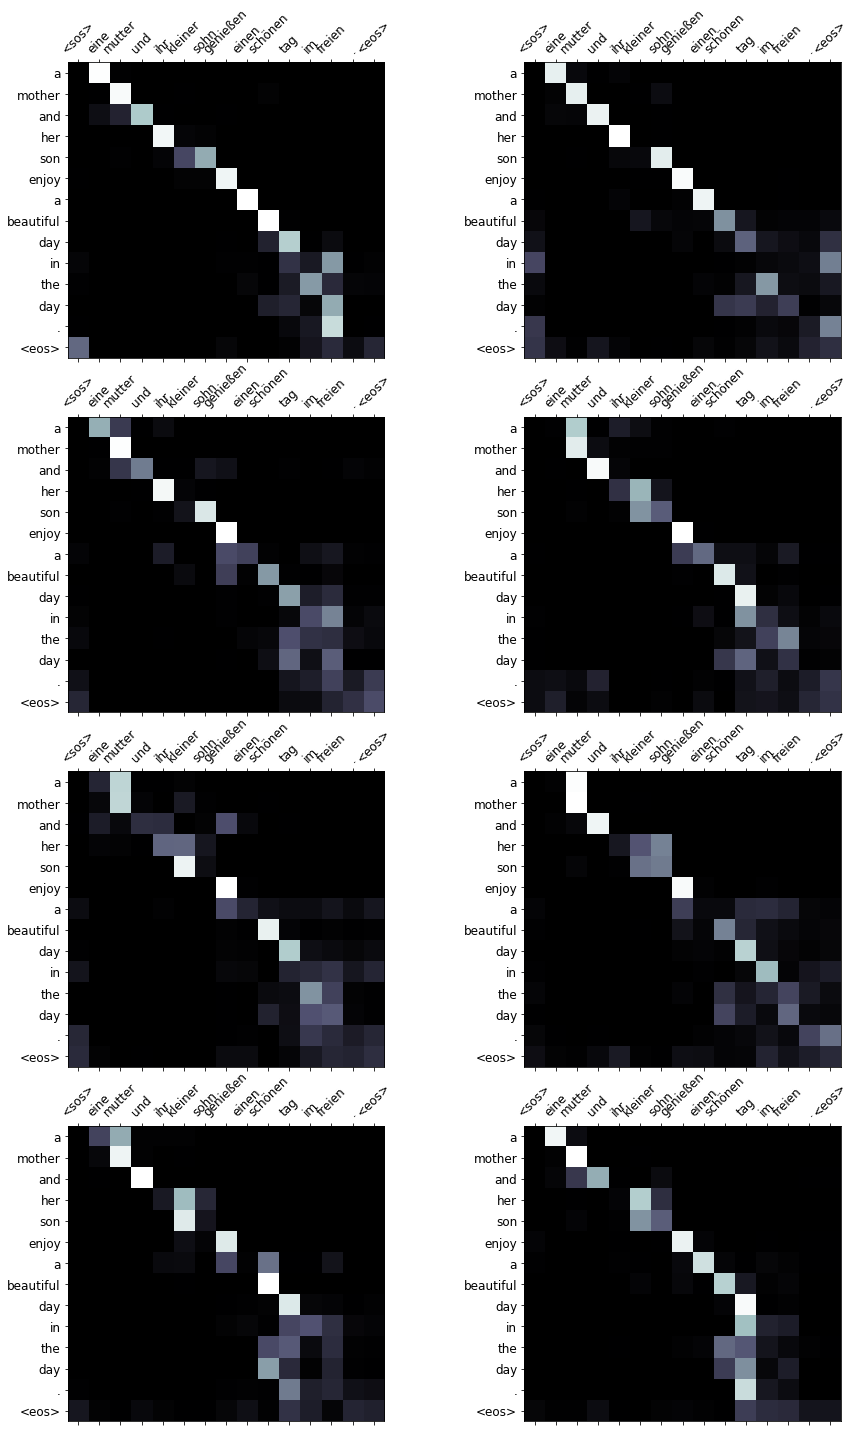

In [19]:
display_attention(src, translation, attention)